In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def hh_gating(Voltage, dt, current_gate, Temperature):
    
    alphaVar = np.zeros(3)
    betaVar = np.zeros(3)
    
    alphaVar[0] = 1000 * ((2.5 - 100 * Voltage) / (np.exp(2.5 - 100 * Voltage) - 1))
    betaVar[0] = 4000 * np.exp(-500 * Voltage / 9)

    alphaVar[1] = 1000 * ((0.1 - 10 * Voltage) / (np.exp(1 - 100 * Voltage) - 1))
    betaVar[1] = 125 * np.exp(-25 * Voltage / 2)

    alphaVar[2] = 70 * np.exp(-50 * Voltage)
    betaVar[2] = 1000 / (np.exp(3 - 100 * Voltage) + 1)

    k = 3 ** (0.1 * (Temperature - 6.3))

    A = -k * (alphaVar + betaVar)
    B = k * alphaVar

    array_g = np.zeros(3)

    array_g[0] = current_gate[0] * np.exp(A[0] * dt) + (B[0] / A[0]) * (np.exp(A[0] * dt) - 1)
    array_g[1] = current_gate[1] * np.exp(A[1] * dt) + (B[1] / A[1]) * (np.exp(A[1] * dt) - 1)
    array_g[2] = current_gate[2] * np.exp(A[2] * dt) + (B[2] / A[2]) * (np.exp(A[2] * dt) - 1)

    return array_g

In [3]:
def hh_potential(Voltage, dt, I_ions, I_stim):

    C_m = 1e-6
    I_i = np.sum(I_ions)
    eqn = (1 / C_m) * (I_stim - I_i)
    V_c = Voltage + dt * eqn
    return V_c


In [4]:
def hh_model(I_stim, t_end, dt, Temperature):
    # Definitions and constants
    Vrest = 0e-3
    t = np.arange(0, t_end, dt)

    V_Na = 115e-3
    V_K = -12e-3
    V_L = 10.6e-3
    g_Na = 120e-3
    g_K = 36e-3
    g_L = 0.3e-3

    alpha_m = lambda V: 1000 * ((2.5 - 100 * V) / (np.exp(2.5 - 100 * V) - 1))
    beta_m = lambda V: 4000 * np.exp(-500 * V / 9)

    alpha_n = lambda V: 1000 * ((0.1 - 10 * V) / (np.exp(1 - 100 * V) - 1))
    beta_n = lambda V: 125 * np.exp(-25 * V / 2)

    alpha_h = lambda V: 70 * np.exp(-50 * V)
    beta_h = lambda V: 1000 / (np.exp(3 - 100 * V) + 1)
    
    t = np.arange(0, t_end + dt, dt)

    V = np.zeros(len(t))
    gates = np.zeros((3, len(t)))
    I_ions = np.zeros((3, len(t)))

    # Initial calculations
    V[0] = Vrest
    alpha_0 = np.array([alpha_m(V[0]), alpha_n(V[0]), alpha_h(V[0])])
    beta_0 = np.array([beta_m(V[0]), beta_n(V[0]), beta_h(V[0])])

    gates[:, 0] = alpha_0 / (alpha_0 + beta_0)

    # Iterative calculation of the membrane potential
    for i in range(len(t) - 1):
        try:
            I_ions[0, i] = g_Na * (gates[0, i] ** 3) * gates[2, i] * (V[i] - V_Na)
            I_ions[1, i] = g_K * (gates[1, i] ** 4) * (V[i] - V_K)
            I_ions[2, i] = g_L * (V[i] - V_L)

            V[i + 1] = hh_potential(V[i], dt, I_ions[:, i], I_stim[i])
            gates[:, i + 1] = hh_gating(V[i], dt, gates[:, i], Temperature)
        except Exception as e:
            # Handle the error by using the previous value for the current index
            continue

    return V, gates, I_ions, t


In [5]:
# 1) Define Variables

t_end = 100e-3
dt = 0.01e-3
Temp1 = 6.3
Temp2 = 28

# 2) Create two stimulation currents

i_v = 5e-3
i_z = 10e-3

I_stim1 = np.concatenate([
    (2e-6) * np.ones(int(i_v / dt)),
    np.zeros(int(i_z / dt)),
    (3e-6) * np.ones(int(i_v / dt)),
    np.zeros(int(i_z / dt)),
    (4e-6) * np.ones(int(i_v / dt)),
    np.zeros(int(i_z / dt)),
    (6e-6) * np.ones(int(i_v / dt)),
    np.zeros(int(i_z / dt)),
    (8e-6) * np.ones(int(i_v / dt)),
    np.zeros(3500)
])

I_stim2 = np.concatenate([
    (2e-6) * np.ones(int(i_v / dt)),
    np.zeros(int(i_z / dt)),
    (4e-6) * np.ones(int(i_v / dt)),
    np.zeros(int(i_z / dt)),
    (8e-6) * np.ones(int(i_v / dt)),
    np.zeros(int(i_z / dt)),
    (16e-6) * np.ones(int(i_v / dt)),
    np.zeros(int(i_z / dt)),
    (32e-6) * np.ones(int(i_v / dt)),
    np.zeros(3500)
])

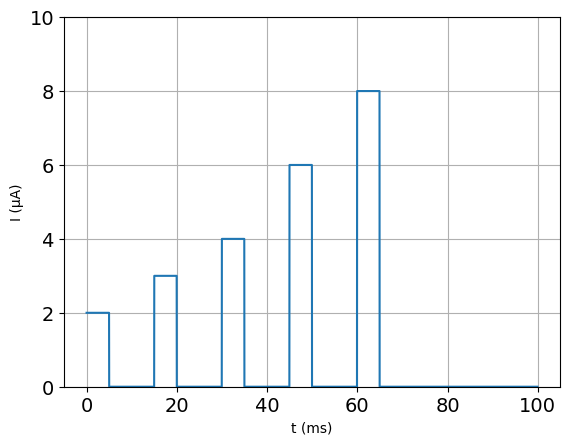

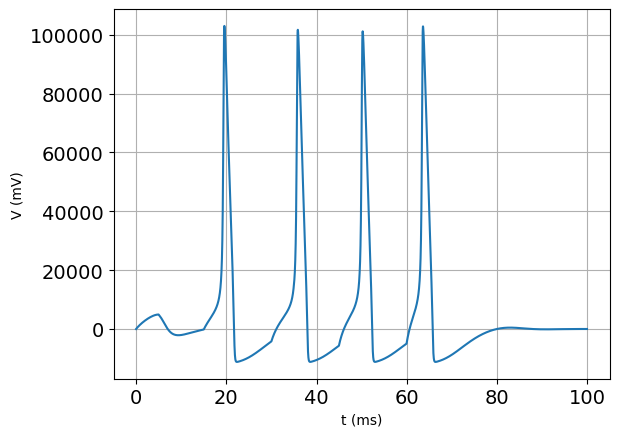

In [6]:
# 3) Run the hh_model function for both stimuli (with different temperatures)

Volt1, gates1, I_ions1, t1 = hh_model(I_stim1, t_end, dt, Temp1)
Volt2, gates2, I_ions2, t2 = hh_model(I_stim2, t_end, dt, Temp2)

# Plot 1 a): Input current I_stim1 for simulation at 6.3°C
t = t1[:len(I_stim1)] * 1e3
plt.figure()
plt.plot(t, I_stim1 * 1e6)
plt.ylabel("I (\u03BCA)")
plt.xlabel("t (ms)")
plt.ylim([0, 10])
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('Fig 5 graphIInput1.png', format='png', dpi=300, bbox_inches='tight')

Volt1 = Volt1[:len(I_stim1)] * 1e3

plt.figure()
plt.plot(t, Volt1 * 1e3)
plt.ylabel("V (mV)")
plt.xlabel("t (ms)")
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('Fig 7 graphV1.png', format='png', dpi=300, bbox_inches='tight')


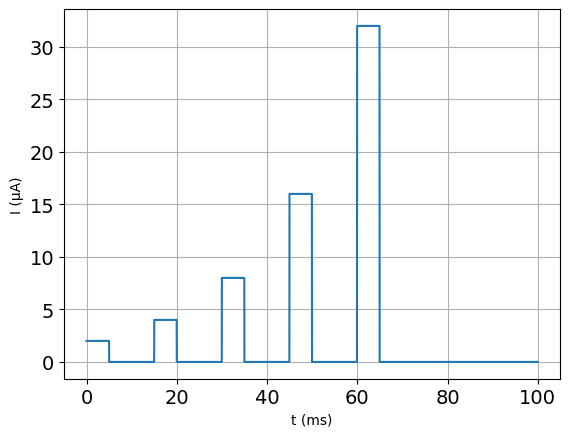

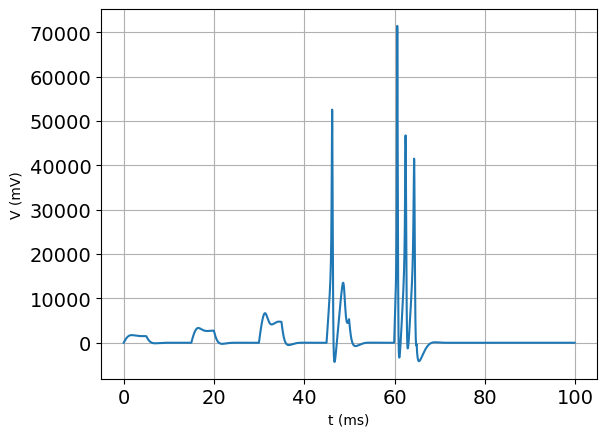

In [7]:
# Plot 1 b): Input current I_stim2 for simulation at 28°C
t = t2[:len(I_stim2)] * 1e3
plt.figure()
plt.plot(t, I_stim2 * 1e6)
plt.ylabel("I (\u03BCA)")
plt.xlabel("t (ms)")
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('Fig 6 graphIInput2.png', format='png', dpi=300, bbox_inches='tight')

t = t2[:len(I_stim2)] * 1e3
Volt2 = Volt2[:len(I_stim2)] * 1e3
# Plot 2 b): Membrane Potential for I_stim2 and 28°C
plt.figure()
plt.plot(t, Volt2 * 1e3)
plt.ylabel("V (mV)")
plt.xlabel("t (ms)")
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('Fig 8 graphV2.png', format='png', dpi=300, bbox_inches='tight')

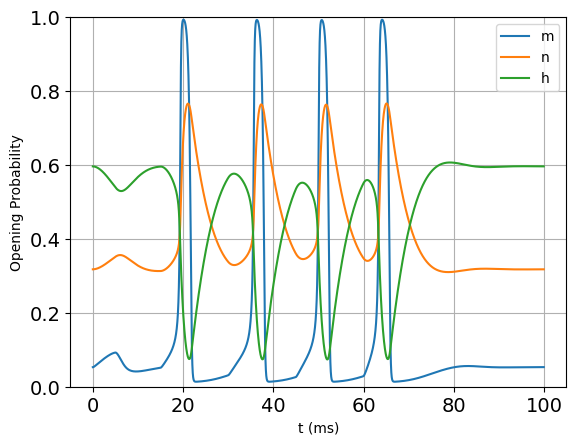

In [8]:
t = t1[:len(I_stim1)] * 1e3
gates1 = gates1[:, :len(I_stim1)]
# Plot 3 a): Gating Variables for I_stim1 and 6.3°C
plt.figure()
plt.plot(t, gates1[0, :])
plt.plot(t, gates1[1, :])
plt.plot(t, gates1[2, :])
plt.ylabel("Opening Probability")
plt.xlabel("t (ms)")
plt.legend(["m", "n", "h"])
plt.ylim([0, 1])
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('Fig 9 graphx1.png', format='png', dpi=300, bbox_inches='tight')


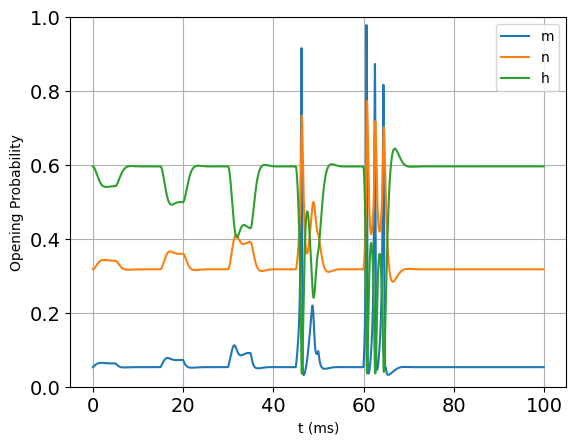

In [9]:
t = t2[:len(I_stim2)] * 1e3
gates2 = gates2[:, :len(I_stim2)]
# Plot 3 b): Gating Variables for I_stim2 and 28°C
plt.figure()
plt.plot(t, gates2[0, :])
plt.plot(t, gates2[1, :])
plt.plot(t, gates2[2, :])
plt.ylabel("Opening Probability")
plt.xlabel("t (ms)")
plt.legend(["m", "n", "h"])
plt.ylim([0, 1])
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('Fig 10 graphx2.png', format='png', dpi=300, bbox_inches='tight')

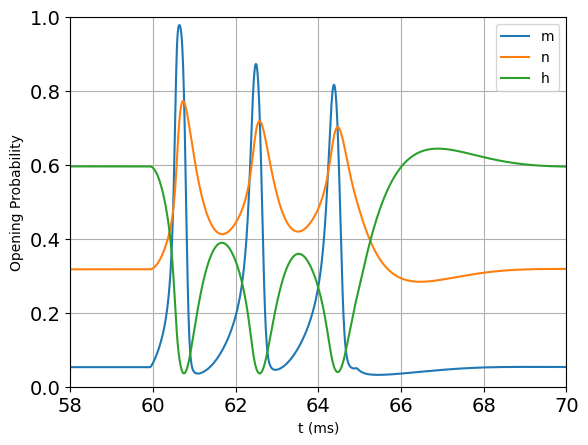

In [10]:
# Specify the time window for the zoomed-in region (adjust as needed)
zoom_start = 5800  # Start index for zoom
zoom_end = 7000   # End index for zoom

# Zoomed-in plot for Gating Variables for I_stim2 and 28°C
plt.figure()
plt.plot(t, gates2[0, :], label='m')
plt.plot(t, gates2[1, :], label='n')
plt.plot(t, gates2[2, :], label='h')
plt.ylabel("Opening Probability")
plt.xlabel("t (ms)")
plt.legend()
plt.ylim([0, 1])
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Set x-axis limits for zoomed-in region
plt.xlim(t[zoom_start], t[zoom_end])

# Save the zoomed-in plot
plt.savefig('Fig_13_zoomed_graphx2.png', format='png', dpi=300, bbox_inches='tight')

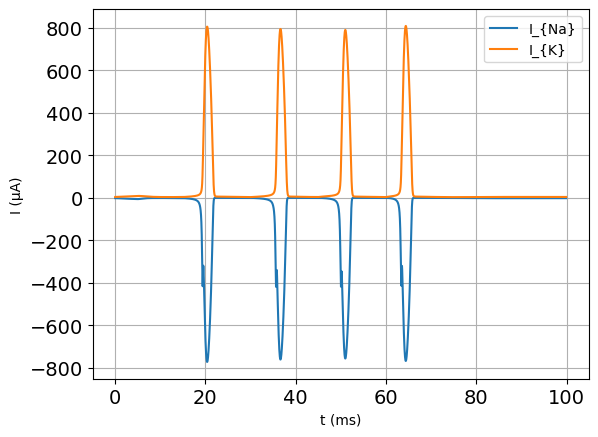

In [11]:
t = t1[:len(I_stim1)] * 1e3
I_ions1 = I_ions1[:, :len(I_stim1)]
# Plot 4 a): Currents I_Na and I_K for I_stim1 and 6.3°C
plt.figure()
plt.plot(t, I_ions1[0, :] * 1e6)
plt.plot(t, I_ions1[1, :] * 1e6)
plt.ylabel("I (\u03BCA)")
plt.xlabel("t (ms)")
plt.legend(["I_{Na}", "I_{K}"])
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('Fig 11 graphI1.png', format='png', dpi=300, bbox_inches='tight')

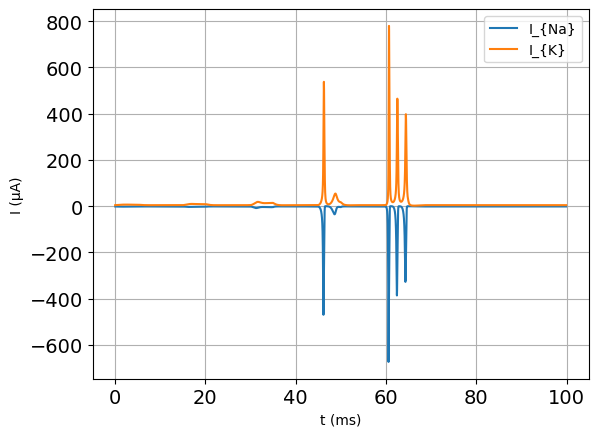

In [12]:
t = t2[:len(I_stim2)] * 1e3
I_ions2 = I_ions2[:, :len(I_stim2)]
# Plot 4 b): Currents I_Na and I_K for I_stim2 and 28°C
plt.figure()
plt.plot(t, I_ions2[0, :] * 1e6)
plt.plot(t, I_ions2[1, :] * 1e6)
plt.ylabel("I (\u03BCA)")
plt.xlabel("t (ms)")
plt.legend(["I_{Na}", "I_{K}"])
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('Fig 12 graphI2.png', format='png', dpi=300, bbox_inches='tight')